## Run cross-correlation between the template light curves and the observed data before/after EVEREST (K2 c8 channel 35)
11 April 2019

In [16]:
from analysis import *

import everest 

import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [2]:
agn_df = pd.read_csv("object_keys/c8_agn_w_redshift.csv")

# load in observed light curves
agn = np.load('/home/rachel/Research/K2/c8_known_z_lc.npy')
# load array containing spurious cadences masks
agn_sc = np.load('/home/rachel/Research/K2/c8_known_z_spur_cad.npy').astype(bool) 
# load in gini coefficients
agn_gini = np.load('/home/rachel/Research/K2/c8_known_z_gini.npy')

# cut to agn in specific channel (35)
ch35 = agn_df[agn_df['CHANNEL']==35]
ch35_lc = agn[agn_df['CHANNEL']==35]
ch35_sc = agn_sc[agn_df['CHANNEL']==35]
ch35_gini = agn_gini[agn_df['CHANNEL']==35]

In [3]:
# load template light curves
mag_med_bin_edges = np.loadtxt("../template_lcs/magbinsC8M11.3.txt")
temp_diff = np.loadtxt("../template_lcs/template_diff_lc_C8M11.3.txt")
temp_med = np.loadtxt("../template_lcs/template_med_lc_C8M11.3.txt")

In [11]:
# arrays to save results in 
x_corr_med= np.zeros_like(np.array(ch35.magnitude))
x_corr_dif = np.zeros_like(np.array(ch35.magnitude))

# interpolate spurious cadences 
X = ch35_lc.copy()
cadno = np.arange(X.shape[1]) # get an array to serve as our time/cadence measurement

for index,lc in enumerate(X):
    
    # extract spurious cadences for given object
    spurious_cad = ch35_sc[index] 
    
    # interp spurious cadences to zero
    interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc[~spurious_cad])
    # replace spurious cadence values with the interpolated values
    lc[spurious_cad] = interped_vals
    
    #X[index] = lc
    
    # extract magnitude
    mag = np.array(ch35.magnitude)[index]
    
    # calculate which magnitude bin object falls into
    ind = np.where((mag - mag_med_bin_edges) < 0)[0][-1]

    # extract proper template lc for that magnitude
    template_lc_med = temp_med[:,ind]
    template_lc_dif = temp_diff[:,ind]
    
    # calculate max X-corr
    x_corr_med[index] = np.max(norm_xcorr(lc, template_lc_med))
    x_corr_dif[index] = np.max(norm_xcorr(lc, template_lc_dif))

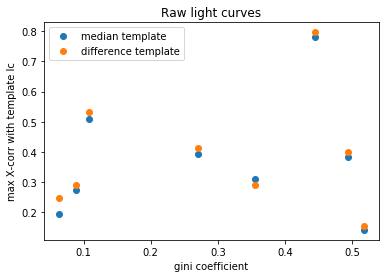

In [15]:
plt.plot(ch35_gini, x_corr_med, 'o', label="median template")
plt.plot(ch35_gini, x_corr_dif, 'o', label="difference template")
plt.xlabel('gini coefficient')
plt.ylabel('max X-corr with template lc')
plt.title ('Raw light curves')
plt.legend()

Trying to find a relationship between the "strength" of the systematics and how extended a source is (how in-focus it appears). There is no clear relationship in these 8 data points.

### Try it with the EVEREST lightcurves

In [33]:
# arrays to save results in 
x_corr_med_eve = np.zeros_like(np.array(ch35.magnitude))
x_corr_dif_eve = np.zeros_like(np.array(ch35.magnitude))

campaign = 8 
for index,epic in enumerate(np.array(ch35['EPIC ID'])):
    lc_everest = everest.Everest(epic, season=8)
    
    # sort flux by time 
    sorting = np.array(lc_everest.time[~lc_everest.mask]).argsort()
    
    # extract magnitude
    mag = np.array(ch35.magnitude)[index]
    
    # calculate which magnitude bin object falls into
    ind = np.where((mag - mag_med_bin_edges) < 0)[0][-1]

    # extract proper template lc for that magnitude
    template_lc_med = temp_med[:,ind]
    template_lc_dif = temp_diff[:,ind]
    
    # calculate max X-corr
    x_corr_med_eve[index] = np.max(norm_xcorr(lc_everest.flux[~lc_everest.mask][sorting], template_lc_med))
    x_corr_dif_eve[index] = np.max(norm_xcorr(lc_everest.flux[~lc_everest.mask][sorting], template_lc_dif))

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220212788.
0
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220212670.
0
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220220757.
0
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220221035.
0
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220192831.
0
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220216359.
0


ValueError: Invalid target ID.

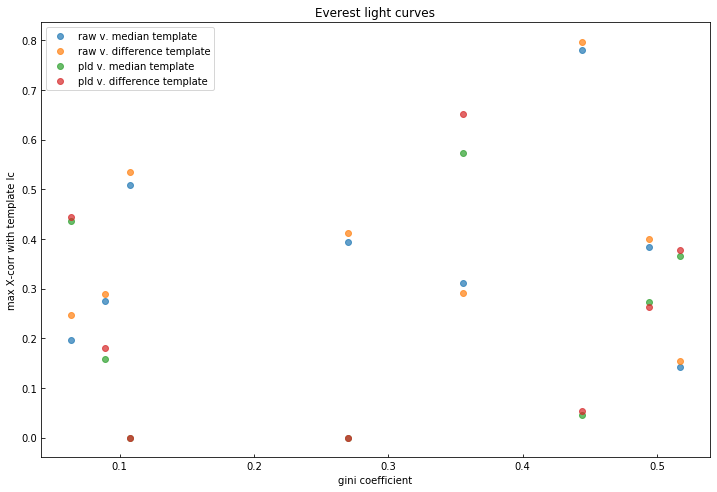

In [39]:
sort = np.array(ch35_gini).argsort()

plt.figure(figsize=(12,8))
plt.plot(ch35_gini[sort], x_corr_med[sort], 'o', label="raw v. median template", alpha=0.7)
plt.plot(ch35_gini[sort], x_corr_dif[sort], 'o', label="raw v. difference template", alpha=0.7)
plt.plot(ch35_gini[sort], x_corr_med_eve[sort], 'o', label="pld v. median template", alpha=0.7)
plt.plot(ch35_gini[sort], x_corr_dif_eve[sort], 'o', label="pld v. difference template", alpha=0.7)
plt.xlabel('gini coefficient')
plt.ylabel('max X-corr with template lc')
plt.title ('Everest light curves')
plt.legend()

The two points that are at 0.0 for pld were not computed. Disregarding them, it there isn't a clear relationship from these 6 data points.

---
### See Ed Shaya Galaxies 

Saved flux, time, mask, fluxerr (for raw flux) in a separate folder.

In [51]:
# create a random sample of Ed Shaya galaxies 
shaya_df = pd.read_csv("object_keys/c8_shaya.csv")

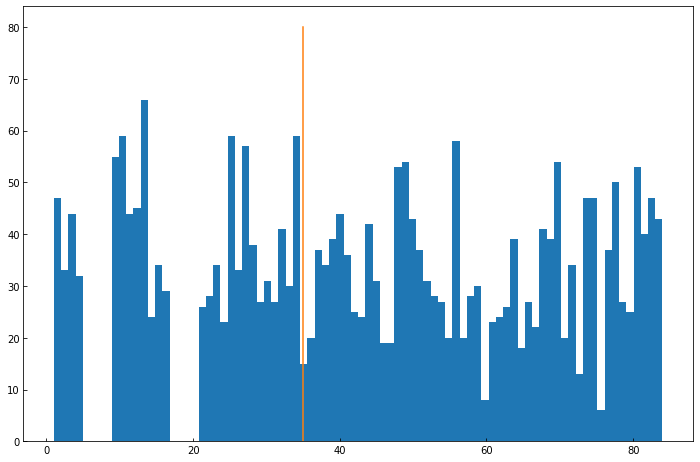

In [66]:
plt.figure(figsize=(12,8))
plt.hist(np.array(shaya_df["CHANNEL"]), bins=np.max(np.array(shaya_df["CHANNEL"])))
plt.plot([35,35],[0,80])

**WELP it looks like channel 35 only has 15 shaya objects. We want atleast 50. **

We need to look at either ch 13 (4 AGN, 66 shaya) or ch 81 (4 AGN, 53 shaya). Channel 13 seems to have clearer systematics than channel 81, so **we'll use 13.**

In [84]:
np.bincount(np.array(shaya_df["CHANNEL"])).argsort()

array([ 0, 20, 19, 18,  5,  6,  7,  8, 17, 76, 60, 73, 35, 65, 47, 46, 36,
       57, 55, 71, 67, 61, 24, 62, 14, 43, 80, 42, 63, 21, 29, 66, 31, 79,
       54, 58, 53, 22, 16, 59, 33, 52, 45, 30,  4, 26,  2, 23, 15, 72, 38,
       41, 77, 51, 37, 28, 64, 69, 39, 82, 68, 32, 44, 84, 50, 40, 11,  3,
       12,  1, 83, 75, 74, 78, 81, 48, 49, 70,  9, 27, 56, 25, 10, 34, 13])

In [98]:
np.bincount(np.array(agn_df["CHANNEL"]).astype(int))[13]

4

In [100]:
np.bincount(np.array(shaya_df["CHANNEL"]))[81]

53

In [102]:
# cut to channel 13
shaya_ch = shaya_df[shaya_df["CHANNEL"]==13]

In [104]:
# save as a single 
shaya_ch.sample(50).to_csv("object_keys/c8_shaya_ch13_random50.csv",index=False)

In [108]:
everest.Everest(np.array(shaya_ch['EPIC ID'])[0], season=8)

INFO  [everest.user.DownloadFile()]: Downloading the file...
ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/52492/hlsp_everest_k2_llc_220252492-c08_kepler_v2.0_lc.fits'


Exception: Unable to locate the file.